In [39]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import lightgbm as lgb
import numpy as np
import shap
import plotly.express as px


In [40]:
PROCESSED_PATH = "../data/processed/"

df = pd.read_csv(os.path.join(PROCESSED_PATH, 'model_ready_dataset_5min.csv'))
print(df.columns)

df.head()

Index(['INTERVALSTARTTIME_GMT', 'RTM_CONG_PRC', 'RTM_ENE_PRC', 'RTM_LOSS_PRC',
       'RTM_PRC', 'DAM_CONG_PRC', 'DAM_ENE_PRC', 'DAM_GHG_PRC', 'DAM_LOSS_PRC',
       'DAM_PRC', '2DA_LOAD', 'RTPD_DMND', 'RTPD_PRC', 'RTM_PRC_lag75min',
       'RTM_PRC_lag80min', 'RTM_PRC_lag85min', 'RTM_PRC_lag90min',
       'RTM_PRC_lag24hr', '2DA_LOAD_lag1', 'RTPD_DMND_lag1', 'hour',
       'dayofweek', 'month', 'is_weekend', 'is_night'],
      dtype='object')


,INTERVALSTARTTIME_GMT,RTM_CONG_PRC,RTM_ENE_PRC,RTM_LOSS_PRC,RTM_PRC,DAM_CONG_PRC,DAM_ENE_PRC,DAM_GHG_PRC,DAM_LOSS_PRC,DAM_PRC,...,RTM_PRC_lag85min,RTM_PRC_lag90min,RTM_PRC_lag24hr,2DA_LOAD_lag1,RTPD_DMND_lag1,hour,dayofweek,month,is_weekend,is_night
0,2023-01-02 14:00:00+00:00,0.0,213.26000,0.0,213.26000,0.0,151.1542,0.0,-2.32777,148.82643,...,233.6136,216.0024,115.95011,8565.53,8490.66,14,0,1,False,False
1,2023-01-02 14:05:00+00:00,0.0,197.67000,0.0,197.67000,0.0,151.1542,0.0,-2.32777,148.82643,...,213.2912,233.6136,115.95011,8837.71,8690.41,14,0,1,False,False
2,2023-01-02 14:10:00+00:00,0.0,195.06000,0.0,195.06000,0.0,151.1542,0.0,-2.32777,148.82643,...,218.6124,213.2912,115.95011,8715.03,8690.41,14,0,1,False,False
3,2023-01-02 14:15:00+00:00,0.0,207.27322,0.0,207.27322,0.0,151.1542,0.0,-2.32777,148.82643,...,218.1324,218.6124,115.95011,8756.71,8690.41,14,0,1,False,False
4,2023-01-02 14:20:00+00:00,0.0,244.96500,0.0,244.96500,0.0,151.1542,0.0,-2.32777,148.82643,...,223.1912,218.1324,114.72000,8789.51,8789.51,14,0,1,False,False


In [41]:
# Drop rows with missing values
df = df.dropna()


In [42]:
# Create derived features
df['RTPD_Forecast_dmnd_diff'] = df['RTPD_DMND'] - df['2DA_LOAD']
df['RTM-DAM'] = df['RTM_PRC'] - df['DAM_PRC']

In [43]:
# Define features and target
target = "RTM-DAM"
features = [
    "DAM_PRC",
    "RTPD_PRC",
    "2DA_LOAD",
    "2DA_LOAD_lag1",
    "RTPD_DMND",
    "RTPD_DMND_lag1",
    'RTPD_Forecast_dmnd_diff',
    "hour",
    "dayofweek",
    "month",
    "is_weekend",
    "is_night",
    "RTM_PRC_lag75min",
    "RTM_PRC_lag80min",
    "RTM_PRC_lag85min",
    "RTM_PRC_lag90min",
    "RTM_PRC_lag24hr",
]

# Create lag features if not already done
#if "RTM_PRC_lag1" not in df.columns:
#    df["RTM_PRC_lag1"] = df[target].shift(1)
#    df["RTM_PRC_lag24"] = df[target].shift(24)
#    df = df.dropna()

# Split into train/test
train_size = int(len(df) * 0.8)
train_df = df.iloc[:train_size]

#threshold = 100  # example, adjust for your data
#train_df = train_df[train_df['RTM_PRC'] < threshold]

test_df = df.iloc[train_size:]

X_train, y_train = train_df[features], train_df[target]
X_test, y_test = test_df[features], test_df[target]

# Fit LightGBM model
model = lgb.LGBMRegressor(n_estimators=500, learning_rate=0.025)
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
#mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006430 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3108
[LightGBM] [Info] Number of data points in the train set: 207975, number of used features: 17
[LightGBM] [Info] Start training from score -5.827398


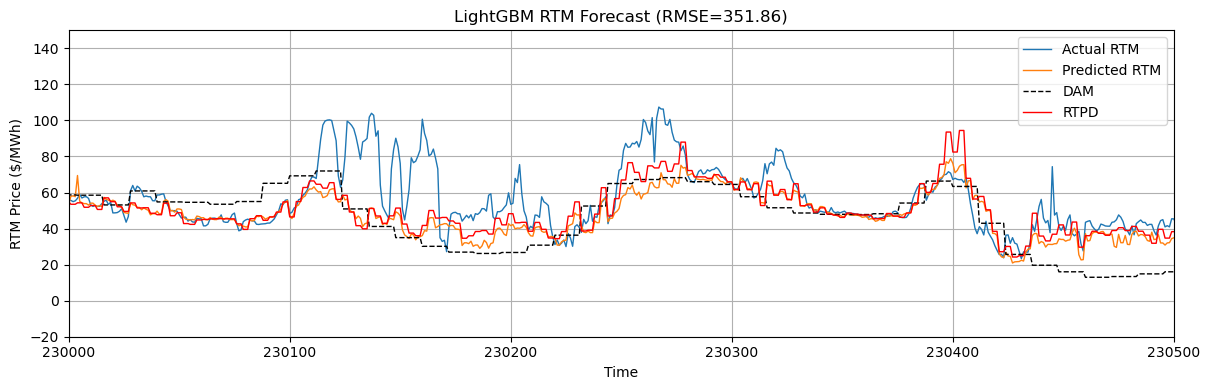

RMSE: 351.86


In [56]:
# Plot predictions vs actual
dam_pred = X_test['DAM_PRC'][y_test.index]

plt.figure(figsize=(12, 4))
plt.plot(y_test.index, y_test.values + dam_pred, label="Actual RTM", linewidth=1)
plt.plot(y_test.index, y_pred + dam_pred, label="Predicted RTM", linewidth=1)
plt.plot(y_test.index, X_test['DAM_PRC'][y_test.index], label='DAM', linewidth=1, color='k', linestyle='--')
plt.plot(y_test.index, X_test['RTPD_PRC'][y_test.index], label='RTPD', linewidth=1, color='r')

plt.title(f"LightGBM RTM Forecast (RMSE={rmse:.2f})")
plt.xlabel("Time")
plt.ylabel("RTM Price ($/MWh)")
plt.legend()
plt.grid(True)
plt.tight_layout()
#plt.xlim(220000, 241000)
plt.xlim(230000, 230500)
plt.ylim(-20, 150)
plt.show()

# Print metrics
#print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")

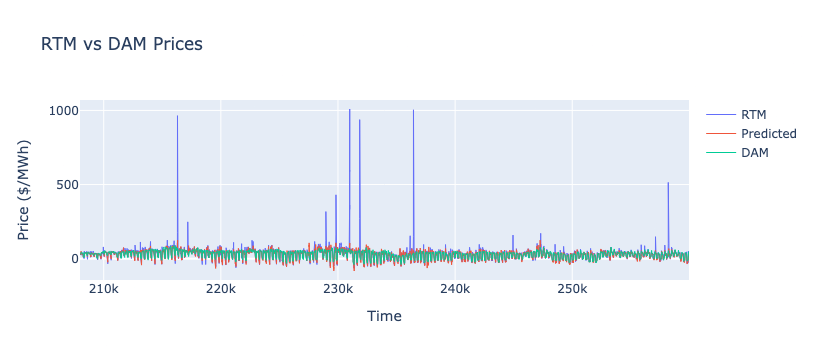

In [50]:
import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(go.Scatter(x=y_test.index, y=y_test.values + dam_pred, mode='lines', name='RTM', line=dict(width=1)))
fig.add_trace(go.Scatter(x=y_test.index, y=y_pred + dam_pred, mode='lines', name='Predicted', line=dict(width=1)))
fig.add_trace(go.Scatter(x=y_test.index, y=dam_pred, mode='lines', name='DAM', line=dict(width=1)))

fig.update_layout(title='RTM vs DAM Prices',
                  xaxis_title='Time',
                  yaxis_title='Price ($/MWh)')
fig.show()


In [51]:
# Feature importance plotting

explainer = shap.Explainer(model)
shap_values = explainer(X_train)



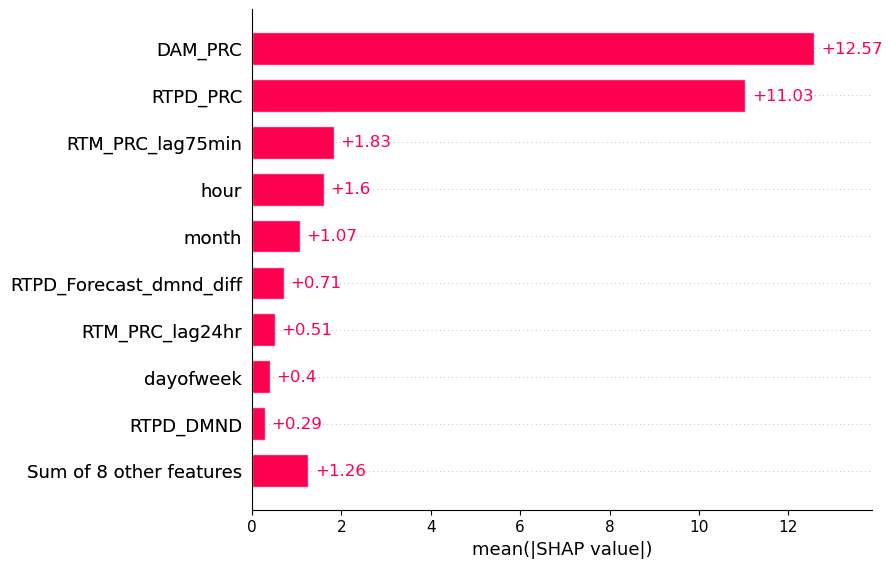

In [52]:
shap.plots.bar(shap_values)

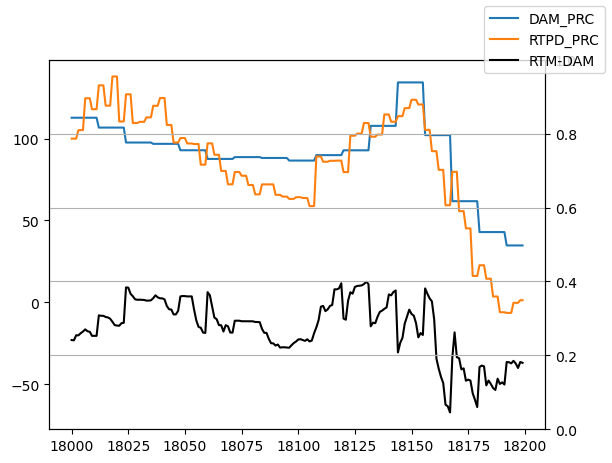

In [38]:
window = np.arange(18000, 18200)
cols = [
    #"RTPD_DMND",
    #"RTPD_DMND_lag1",
    'DAM_PRC',
    'RTPD_PRC',
]
fig, ax = plt.subplots()
ax2 = ax.twinx()
ax.plot(window, df[cols].iloc[window], label=cols)
ax.plot(window, df[target].iloc[window], label=target, color='k')

fig.legend()
plt.grid(True)